# Project 2 
This jupyter notebook file provides strong hints and guidance for setting up simulations of cart-pole system in Drake.

First, we need to import packages

In [1]:
server_args = []
import math
import numpy as np
import pydot
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import display, SVG
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)
from pydrake.all import (LeafSystem,BasicVector,DiagramBuilder, AddMultibodyPlantSceneGraph, Parser, LinearQuadraticRegulator,
                         Simulator, RigidTransform, CoulombFriction, FindResourceOrThrow, DrakeVisualizer, ConnectContactResultsToDrakeVisualizer,
                         RollPitchYaw, JointIndex, namedview, ConnectMeshcatVisualizer,
                         Value, List, ZeroOrderHold, LogOutput, SpatialAcceleration, RotationMatrix, AbstractValue, ConstantVectorSource)

## Design and testing
- You should design your feedback gain K and test its performance in the simulation 
- Note that the plant is represented in continuous time model, but our design was based on discrete time linearized model (with sampling time T), you need to add the zero-order-holder between the feedback gain block and the plant. In other words, the control action will be sent to the plant every T second (not continuously)
- In the simulator, you can get everything from the plant model. In particular, we get all the state vector from the plant using "get_state_output_port()". This is a special port for the MultibodyPlant class (this class of systems can be defined from the urdf file)
- If you want to use only part of the full state, say [$\theta$, $\dot\theta$], then we can extract these info from the full state info. 

### Q5

In [5]:
builder = DiagramBuilder()
# First add the cart-pole system from a urdf file
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
urdf_path = "./urdfExample_cart_pole.urdf"    
cart_pole = Parser(plant, scene_graph).AddModelFromFile(urdf_path)    
plant.Finalize()

# Add controller (u = 0)
controller = builder.AddSystem(ConstantVectorSource([0]))

# connect to make diagram
builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

# set up visualization using meshcat
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, open_browser=True)
diagram = builder.Build()

# start simulation
UprightState = np.array([0, np.pi, 0, 0])
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()
context.SetContinuousState(UprightState + np.array([-1.0, 0.0, 0.0, -0.5]))
simulator.Initialize()

sim_time = 5
meshcat.start_recording() 
simulator.AdvanceTo(sim_time)
meshcat.stop_recording()
meshcat.publish_recording()
simulator.AdvanceTo(sim_time)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


### Q6

In [6]:
import numpy as np
import scipy.signal as sig
import scipy.linalg as la

# convert continuous-time to discrete-time
T = 0.005
A =np.mat('1, 0.005; 0.10791, 1')
B =np.mat('0; 0.001')
C =np.mat('1, 0')

s_desired = np.array([-2+1j, -2-1j])
z_desired = np.exp(s_desired*T)

K = sig.place_poles(A, B, z_desired).gain_matrix
print(K)

[[132.66140054  19.9250837 ]]


In [16]:
# Define the controller.
class state_feedback(LeafSystem):
    def __init__(self, gain):
        LeafSystem.__init__(self)        
        num_input = 4
        num_output = 1
        # Define the input
        self.DeclareVectorInputPort("x_all", BasicVector(num_input))
        # Define the output
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY)
        self.gain = gain
    def CalcOutputY(self, context, output):        
        x_all = self.get_input_port(0).Eval(context)
        x_theta = np.array([[x_all[1]],[x_all[3]]])
        y = self.gain@(x_theta - np.array([[np.pi], [0]]))
        output.SetFromVector(y)

In [20]:
from pydrake.all import ZeroOrderHold

builder = DiagramBuilder()

# First add the cart-pole system from a urdf file
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
urdf_path = "./urdfExample_cart_pole.urdf"
cart_pole = Parser(plant, scene_graph).AddModelFromFile(urdf_path)    
plant.Finalize()

# Add controller (you need to design your feedback gain K first)
controller = builder.AddSystem(state_feedback(-K))
zoh = builder.AddSystem(ZeroOrderHold(T,1))  # add the zoh to simulate the discrete update effect

# connect to make diagram
builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))  # get_state_output_port()  will return the full state
# in this case, the full state =[z, theta, zdot, theta_dot] 
builder.Connect(zoh.get_output_port(0), plant.get_actuation_input_port())
builder.Connect(controller.get_output_port(0), zoh.get_input_port(0))

logger_output_u = LogOutput(controller.get_output_port(0), builder)
logger_output_state = LogOutput(plant.get_state_output_port(), builder)

# set up visualization using meshcat
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, open_browser=True)
diagram = builder.Build()

# start simulation
UprightState = np.array([0, np.pi, 0, 0])   # the state of the cart-pole is organized as [z, theta, zdot, theta_dot]
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()
context.SetContinuousState(UprightState + np.array([0.0, 0.5, 0.0, 0.1]))
simulator.Initialize()

sim_time = 5
meshcat.start_recording() 
simulator.AdvanceTo(sim_time)
meshcat.stop_recording()
meshcat.publish_recording()
simulator.AdvanceTo(sim_time)

/opt/drake/lib/python3.8/site-packages/pydrake/common/cpp_template.py:392: DrakeDeprecationWarning: (Deprecated.)

Deprecated:
    Use LogVectorOutput instead. This will be removed from Drake on or
    after 2021-12-01.
  def f(*args, **kwargs): return orig(*args, **kwargs)


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


<Figure size 432x288 with 0 Axes>

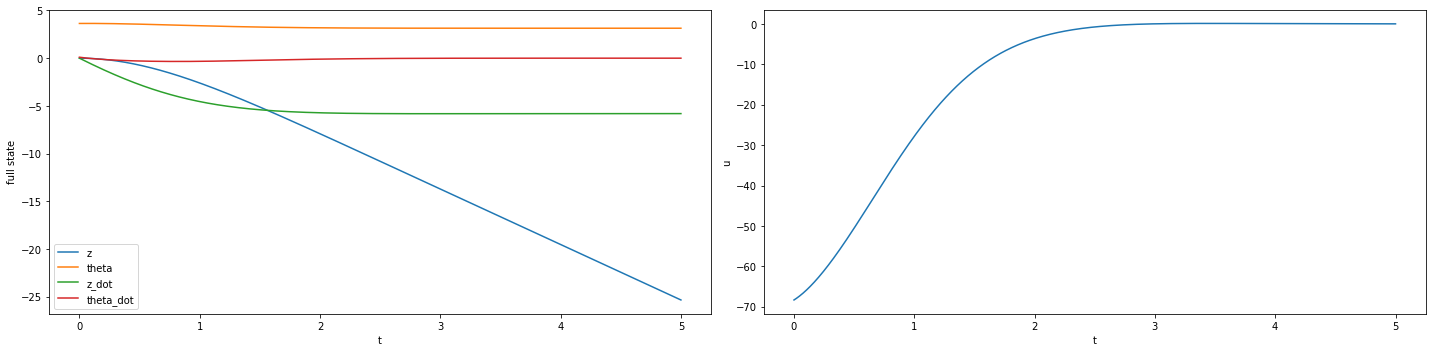

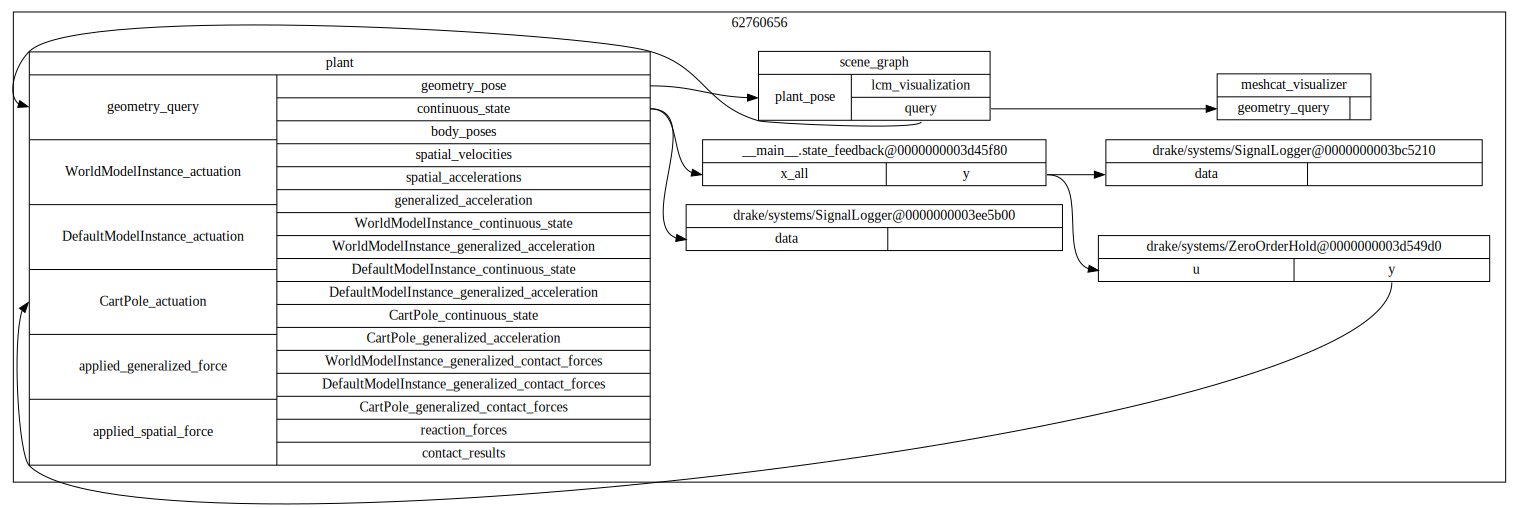

In [21]:
import matplotlib.pyplot as plt
from IPython.display import display, SVG

# Plot response
plt.figure()
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(logger_output_state.sample_times(), logger_output_state.data().transpose())
plt.xlabel('t')
plt.ylabel('full state')
plt.legend(["z","theta","z_dot","theta_dot"])

plt.subplot(1,2,2)
plt.plot(logger_output_u.sample_times(), logger_output_u.data().transpose())
plt.xlabel('t')
plt.ylabel('u')

plt.tight_layout()
plt.show()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

### Q7

In [22]:
# Define the controller.
class state_feedback(LeafSystem):
    def __init__(self, gain):
        LeafSystem.__init__(self)     
        num_input = 4
        num_output = 1
        # Define the input
        self.DeclareVectorInputPort("x_all", BasicVector(num_input))
        # Define the output
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY)
        self.gain = gain
    def CalcOutputY(self, context, output):        
        x_all = self.get_input_port(0).Eval(context)
        x_theta = np.array([[x_all[1]],[x_all[3]]])
        y = self.gain @ (x_theta - np.array([[np.pi], [0]]))
        output.SetFromVector(y)

In [29]:
import scipy.signal as sig
import scipy.linalg as la

# convert continuous-time to discrete-time
T = 0.005
A =np.mat('1, 0.005; 0.10791, 1')
B =np.mat('0; 0.001')
C =np.mat('1, 0')

s_desired = np.array([-2+8*1j, -2-8*1j])
z_desired = np.exp(s_desired*T)

K = sig.place_poles(A, B, z_desired).gain_matrix
print(K)

[[444.48486861  21.48420104]]


In [32]:
from pydrake.all import ZeroOrderHold

builder = DiagramBuilder()

# First add the cart-pole system from a urdf file
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
urdf_path = "./urdfExample_cart_pole.urdf"
cart_pole = Parser(plant, scene_graph).AddModelFromFile(urdf_path)    
plant.Finalize()

# Add controller (you need to design your feedback gain K first)
controller = builder.AddSystem(state_feedback(-K))
zoh = builder.AddSystem(ZeroOrderHold(T,1))  # add the zoh to simulate the discrete update effect

# connect to make diagram
builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))  # get_state_output_port()  will return the full state
# in this case, the full state =[z, theta, zdot, theta_dot]
builder.Connect(zoh.get_output_port(0), plant.get_actuation_input_port())
builder.Connect(controller.get_output_port(0), zoh.get_input_port(0))

logger_output_u = LogOutput(controller.get_output_port(0), builder)
logger_output_state = LogOutput(plant.get_state_output_port(), builder)

# set up visualization using meshcat
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, open_browser=True)
diagram = builder.Build()

# start simulation
UprightState = np.array([0, np.pi, 0, 0])   # the state of the cart-pole is organized as [z, theta, zdot, theta_dot]
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()
context.SetContinuousState(UprightState + np.array([-1.0, -0.8, 0.0, 0.0]))
simulator.Initialize()

sim_time = 5
meshcat.start_recording() 
simulator.AdvanceTo(sim_time)
meshcat.stop_recording()
meshcat.publish_recording()
simulator.AdvanceTo(sim_time)

/opt/drake/lib/python3.8/site-packages/pydrake/common/cpp_template.py:392: DrakeDeprecationWarning: (Deprecated.)

Deprecated:
    Use LogVectorOutput instead. This will be removed from Drake on or
    after 2021-12-01.
  def f(*args, **kwargs): return orig(*args, **kwargs)


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


<Figure size 432x288 with 0 Axes>

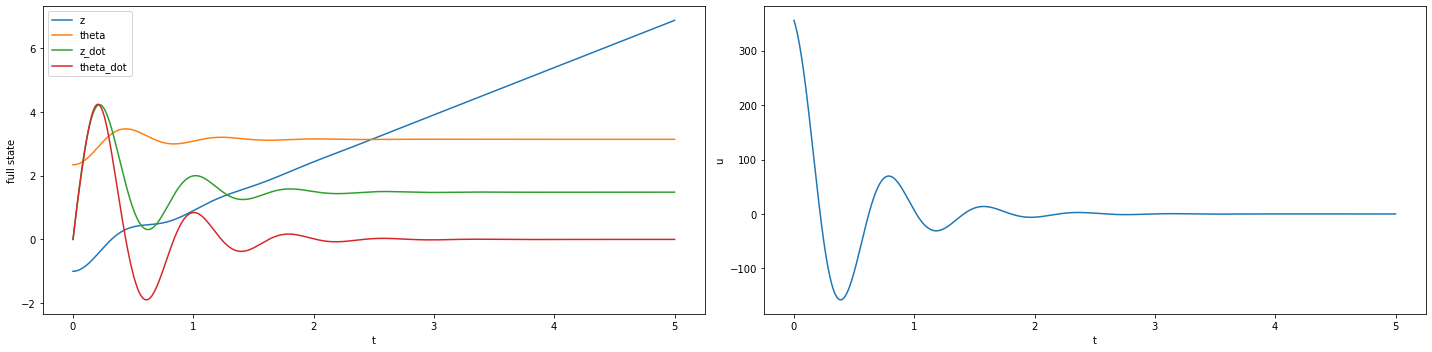

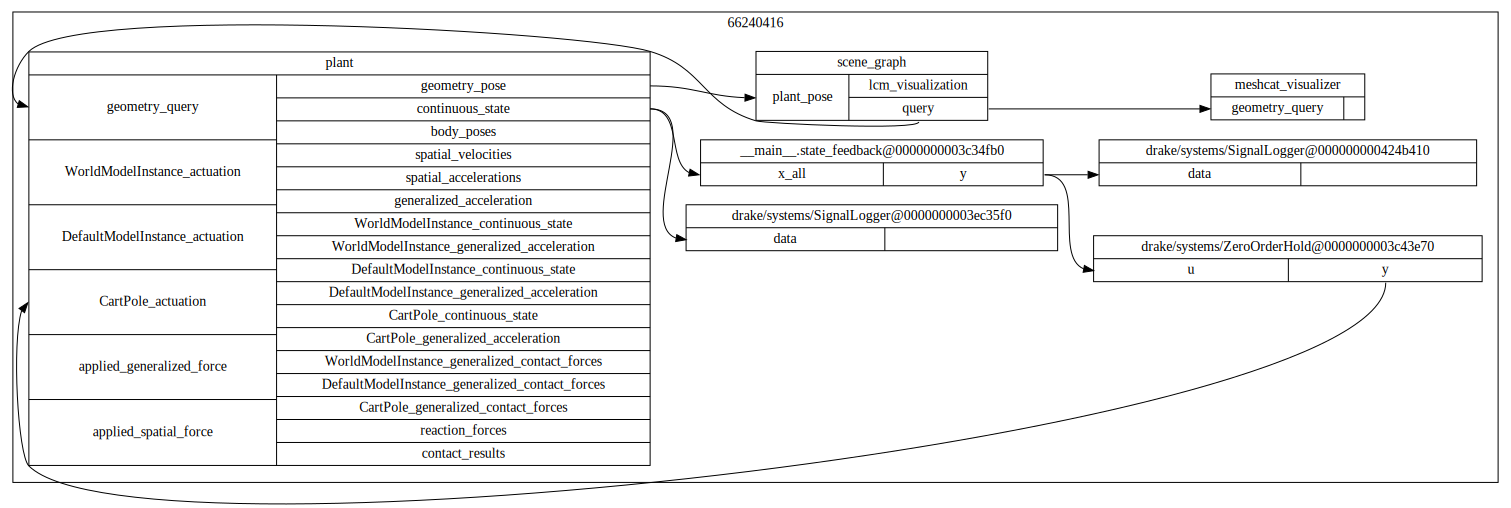

In [33]:
import matplotlib.pyplot as plt
from IPython.display import display, SVG

# Plot response
plt.figure()
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(logger_output_state.sample_times(), logger_output_state.data().transpose())
plt.xlabel('t')
plt.ylabel('full state')
plt.legend(["z","theta","z_dot","theta_dot"])

plt.subplot(1,2,2)
plt.plot(logger_output_u.sample_times(), logger_output_u.data().transpose())
plt.xlabel('t')
plt.ylabel('u')

plt.tight_layout()
plt.show()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

### Q8

In [34]:
import scipy.signal as sig
import scipy.linalg as la

# convert continuous-time to discrete-time
T = 0.005
A =np.mat('1, 0.005; 0.10791, 1')
B =np.mat('0; 0.001')
C =np.mat('1, 0')

s_desired = np.array([-2+1j, -2-1j])
z_desired = np.exp(s_desired*T)

K = sig.place_poles(A, B, z_desired).gain_matrix

obs_eig_s = np.array([-9+2*1j, -9-2*1j])
obs_eig_z = np.exp(obs_eig_s*T)

K_obs = sig.place_poles(A.T, C.T, obs_eig_z)
L = K_obs.gain_matrix.T

#print(obs_eig_z)
#print(la.eig(A-L*C))
#print(K)
print(L)

[[0.08810064]
 [0.51427411]]


In [36]:
# Define the controller.
class output_feedback_ctr(LeafSystem):
    def __init__(self, gain):
        LeafSystem.__init__(self)        
        num_input = 2
        num_output = 1
        # Define the input
        self.DeclareVectorInputPort("x_theta", BasicVector(num_input))
        # Define the output
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY)
        self.gain = gain
        
    def CalcOutputY(self, context, output):     
        x_theta = self.get_input_port(0).Eval(context)
        x_theta = np.array([[x_theta[0]],[x_theta[1]]])
        y = self.gain@(x_theta)
        output.SetFromVector(y)

In [44]:
# Define the observer.
class output_feedback_obs(LeafSystem):
    def __init__(self,A,B,C,L,T):
        LeafSystem.__init__(self)        
        n = A.shape[0]
        m = B.shape[1]
        num_yk = 4
        
        self.DeclareDiscreteState(n)
        # Define the input
        self.DeclareVectorInputPort("uk", BasicVector(m))
        self.DeclareVectorInputPort("yk", BasicVector(num_yk))
        # Define the output
        self.DeclareVectorOutputPort("x_estimated", BasicVector(n), self.CalcOutputY, set([self.all_state_ticket()]))
        self.DeclarePeriodicDiscreteUpdate(T)
        self.A = A
        self.B = B
        self.C = C
        self.L = L
        # get_state_output_port()
    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        xk = context.get_discrete_state_vector().CopyToVector()
        uk = self.get_input_port(0).Eval(context)
        yk = self.get_input_port(1).Eval(context)
        delta_theta = np.array([yk[1]-np.pi])
        A = self.A
        B = self.B 
        C = self.C
        L = self.L
        xk = np.mat(xk.reshape((2,1)))
        xnext = A*xk + B*uk + L*(delta_theta - C*xk)        
        discrete_state.get_mutable_vector().SetFromVector(xnext)
        
    def CalcOutputY(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        y = x
        output.SetFromVector(y)

In [52]:
builder = DiagramBuilder()

# First add the cart-pole system from a urdf file
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
urdf_path = "./urdfExample_cart_pole.urdf"
cart_pole = Parser(plant, scene_graph).AddModelFromFile(urdf_path)    
plant.Finalize()

controller = builder.AddSystem(output_feedback_ctr(-K))
observer = builder.AddSystem(output_feedback_obs(A,B,C,L,T))

# connect to make diagram
builder.Connect(controller.get_output_port(0), plant.get_actuation_input_port()) 
builder.Connect(controller.get_output_port(0), observer.get_input_port(0))
builder.Connect(plant.get_state_output_port(), observer.get_input_port(1))
builder.Connect(observer.get_output_port(0), controller.get_input_port(0))

logger_output_u = LogOutput(controller.get_output_port(0), builder)
logger_output_state = LogOutput(plant.get_state_output_port(), builder)
logger_output_state_estimated = LogOutput(observer.get_output_port(0), builder)

# set up visualization using meshcat
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, open_browser=True)
diagram = builder.Build()

# start simulation
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()

# now let's get subsystem context
UprightState = np.array([0, np.pi, 0, 0])   # the state of the cart-pole is organized as [z, theta, zdot, theta_dot]
plant_context = diagram.GetMutableSubsystemContext(plant, context)
plant_context.SetContinuousState(UprightState + np.array([0, -0.6, 0, 0.2]))
# observer context
observer_context = diagram.GetMutableSubsystemContext(observer, context)
observer_context.SetDiscreteState(np.array([0.4, -0.2]))

simulator.Initialize()

sim_time = 5
meshcat.start_recording() 
simulator.AdvanceTo(sim_time)
meshcat.stop_recording()
meshcat.publish_recording()
simulator.AdvanceTo(sim_time)

/opt/drake/lib/python3.8/site-packages/pydrake/common/cpp_template.py:392: DrakeDeprecationWarning: (Deprecated.)

Deprecated:
    Use LogVectorOutput instead. This will be removed from Drake on or
    after 2021-12-01.
  def f(*args, **kwargs): return orig(*args, **kwargs)


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


<Figure size 432x288 with 0 Axes>

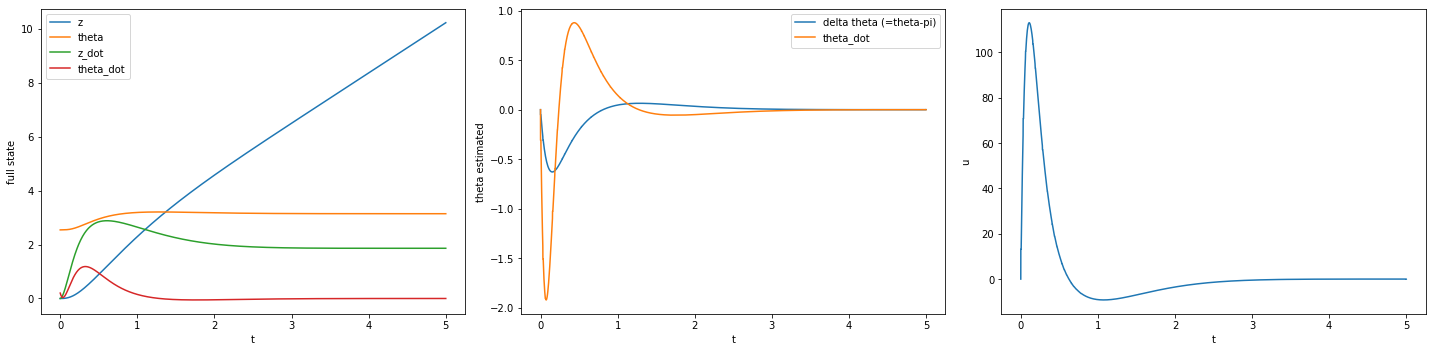

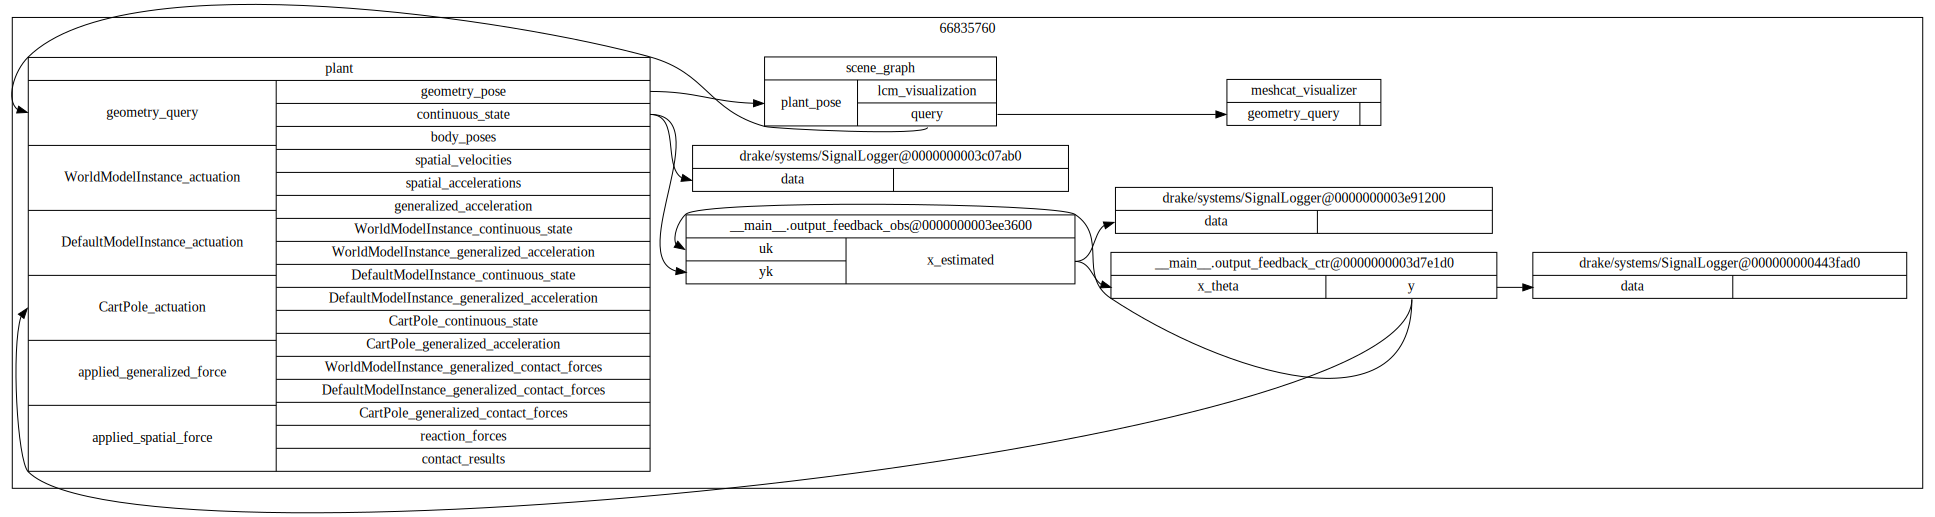

In [53]:
import matplotlib.pyplot as plt
from IPython.display import display, SVG

# Plot response
plt.figure()
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(logger_output_state.sample_times(), logger_output_state.data().transpose())
plt.xlabel('t')
plt.ylabel('full state')
plt.legend(["z","theta","z_dot","theta_dot"])

plt.subplot(1,3,2)
plt.plot(logger_output_state_estimated.sample_times(), logger_output_state_estimated.data().transpose())
plt.xlabel('t')
plt.ylabel('theta estimated')
plt.legend(["delta theta (=theta-pi)", "theta_dot"])

plt.subplot(1,3,3)
plt.plot(logger_output_u.sample_times(), logger_output_u.data().transpose())
plt.xlabel('t')
plt.ylabel('u')

plt.tight_layout()
plt.show()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))